In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

In [2]:
test_num = 6

fwt_modes = 1
modes = 2
main_panels = 20
fwt_panels = 10
panels = main_panels + fwt_panels

# lets go for B2T2 (so 5 DoF)
p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.c = ma.ModelSymbol(value = 1.8,string = 'c') # chord of wing
p.s_t = ma.ModelSymbol(value = 12,string = 's_t') # total semi-span of wing
p.rho_t = ma.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)
p.sigma = ma.ModelSymbol(value = 0.2,string = 'sigma') # percentage of wing that is a FWT


# Respective spans
p.s_0 =  p.s_t*(1-p.sigma) # span of inner wing
p.s_1 =  p.s_t*p.sigma # span of fwt

# Inner Wing stiffness Properties
p.K = ma.ModelSymbol(value = 100,string = 'K') # Bending stiffness for the wing

# Location of flexural axes
p.e_0 = ma.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c
p.e_1 = ma.ModelSymbol(value = 0,string = 'e_1') # e for the FWT
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c

# FWT Properties
# p.m_factor = ma.ModelSymbol(value = 1, string = 'delta_m')
p.m_1 = ma.ModelSymbol(value = 0.3,string = 'm_1')
p.x_com1 = ma.ModelSymbol(value = 0.3,string = 'x_com1')
p.y_com1 = ma.ModelSymbol(value = 0.3,string = 'y_com1')

p.m_2 = ma.ModelSymbol(value = 0.3,string = 'm_2')
p.x_com2 = ma.ModelSymbol(value = 0.3,string = 'x_com2')
p.y_com2 = ma.ModelSymbol(value = 0.3,string = 'y_com2')

p.I_xx1 = ma.ModelSymbol(value = 0.3,string = 'I_xx1') # inertia of FWT (uniform bar)
p.Lambda = ma.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord
p.y_1 = sym.Symbol('y_1') # FWT y chord
p.x_1 = sym.Symbol('x_1') # FWT x chord

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term 

## Main Wing Specific
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l

## FWT Specific
p.alpha_1 = ma.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = ma.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [3]:
#define refernce frames
wing_root_frame = ma.HomogenousTransform().Translate(0,0,p.q[0])

fwt_root_frame = wing_root_frame.R_x(p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(0,p.y_1,0)
fwt_com_frame = fwt_root_frame.Translate(p.x_com1,p.y_com1,0)
fwt_com2_frame = fwt_root_frame.Translate(p.x_com2,p.y_com2,0)

In [4]:
#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx1)
M_k = ele.Spring(p.q[0],p.K)

inner_wing_ele = ele.RigidElement.point_mass(wing_root_frame,p.rho_t,True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)
mass_ele = ele.RigidElement.point_mass(fwt_com2_frame,p.m_2,True)

In [5]:
# FWT Aero Forces
alpha_fwt =  p.alpha_1
alphadot_fwt = p.alphadot_1
# include wing twist in AoA
BodyJacobian = sym.simplify(ef.AeroForce._trigsimp(fwt_flexural_frame.BodyJacobian(p.q)))

(wrench,dAlpha) = ef.AeroForce.get_wrench(p,BodyJacobian,p.a_i,
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               w_g = 0,
                               rootAlpha = alpha_fwt,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                                V = p.V,
                               c_d_max = 0,
                               linear = True,
                                z_inverted=False)


# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda,-p.q[-1])
#fwt_aoa = sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[-1]))

## Sub in Aero Forces
wrench = wrench.subs({p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})
dAlpha = dAlpha.subs({p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})

_Q = BodyJacobian.T*wrench
fwt_AeroForces_perUnit = ef.AeroForce(_Q,dAlpha)

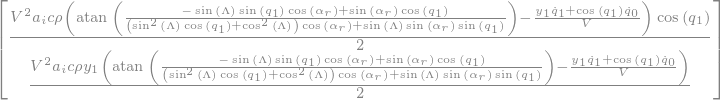

In [6]:
_Q

In [7]:
func = sym.lambdify((p.alpha_r,p.Lambda,p.q[-1]),fwt_aoa,'numpy')

In [8]:
np.rad2deg(func(*np.deg2rad([0,10,10])))

In [9]:
#Transform = wing_root_frame.subs({p.y_0:p.s_0,p.x_0:p.x_f0}).R_y(tau_s0)
#fwt_aeroTorque = ef.BodyForce(p,Transform,simplify=False,)#My = wrench[4]*sym.cos(p.q[-1]))

In [10]:
# split Main Wing into segments
forces = []
for i in range(fwt_panels):
    seg_width = p.s_1/fwt_panels
    yi = 0 + seg_width/2 + i*seg_width
    forces.append(fwt_AeroForces_perUnit.subs({p.y_1:yi,p.a_i:p.a[i+main_panels]})*seg_width)
    #forces.append(fwt_aeroTorque.subs({p.y_1:yi,p.a_i:p.a[i+main_panels]})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
fwt_AeroForces = ef.ExternalForce(Q)

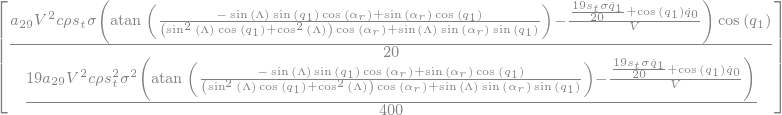

In [11]:
forces[-1].Q()

In [12]:
#Create Composite force
CompositeForce = ef.CompositeForce([fwt_AeroForces])
# Create the SYmbolic Model
sm = ma.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele,mass_ele,M_k],fwt_AeroForces)

In [13]:
sm.to_matlab_file(p,'C:/Git/fwt_auto/model_2DoF/')

In [14]:
sm_lin = sm.linearise(p)
sm_lin.to_matlab_file_linear(p,'C:/Git/fwt_auto/model_2DoF/')

In [15]:
sm_lin.ExtForces.Q().jacobian(p.qd).shape